In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [ ]:
df = pd.read_csv("/content/financial_news.csv", encoding='latin1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
print(df.shape)
df.columns = ['sentiment', 'text']
print(df['sentiment'].value_counts())

(4845, 2)
sentiment
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.head()


,sentiment,text,clean_text
0,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...,the international electronic industry company ...
2,positive,With the new production plant the company woul...,with the new production plant the company woul...
3,positive,According to the company 's updated strategy f...,according to the company s updated strategy fo...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing of aspocomp s growth aspocomp is agg...


In [ ]:
X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

    negative       0.78      0.46      0.58       121
     neutral       0.77      0.95      0.85       576
    positive       0.80      0.53      0.64       272

    accuracy                           0.77       969
   macro avg       0.78      0.65      0.69       969
weighted avg       0.78      0.77      0.76       969



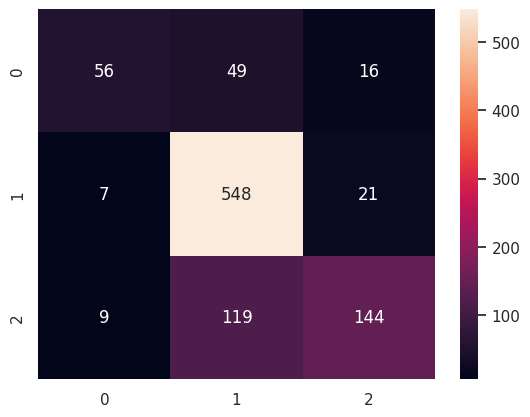

In [ ]:
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [ ]:
!pip install transformers torch


In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [15]:
def llm_sentiment(text):
    result = sentiment_pipeline(text[:512])[0]  # limit length
    label = result["label"]

    if label == "POSITIVE":
        return "Positive"
    elif label == "NEGATIVE":
        return "Negative"
    else:
        return "Neutral"


In [16]:
sample_df = df.sample(50, random_state=42)

sample_df["llm_pred"] = sample_df["clean_text"].apply(llm_sentiment)
sample_df[["text", "sentiment", "llm_pred"]].head()


,text,sentiment,llm_pred
3206,The company was supposed to deliver machinery ...,neutral,Negative
1684,UPM-Kymmene has generated four consecutive qua...,positive,Positive
1044,In the method the smelt spouts 2 are separated...,neutral,Negative
4144,`` That 's a very high figure on the European ...,neutral,Positive
1538,"In Penttil+Æ 's vision , the most important re...",neutral,Positive


In [17]:
ALLOWED_LABELS = ["Positive", "Negative", "Neutral"]

def guardrail(label):
    if label not in ALLOWED_LABELS:
        return "Neutral"
    return label

sample_df["llm_pred"] = sample_df["llm_pred"].apply(guardrail)


In [18]:
from sklearn.metrics import accuracy_score

ml_preds_sample = model.predict(
    vectorizer.transform(sample_df["clean_text"])
)

print("ML Accuracy (sample):",
      accuracy_score(sample_df["sentiment"], ml_preds_sample))

print("LLM Accuracy (sample):",
      accuracy_score(sample_df["sentiment"], sample_df["llm_pred"]))


ML Accuracy (sample): 0.82
LLM Accuracy (sample): 0.0


In [19]:
errors = sample_df[
    sample_df["sentiment"] != sample_df["llm_pred"]
]

errors[["text", "sentiment", "llm_pred"]].head(10)


,text,sentiment,llm_pred
3206,The company was supposed to deliver machinery ...,neutral,Negative
1684,UPM-Kymmene has generated four consecutive qua...,positive,Positive
1044,In the method the smelt spouts 2 are separated...,neutral,Negative
4144,`` That 's a very high figure on the European ...,neutral,Positive
1538,"In Penttil+Æ 's vision , the most important re...",neutral,Positive
1034,"FinancialWire tm is a fully independent , prop...",neutral,Positive
2107,"Following the payment made in April , the comp...",neutral,Positive
4256,The gross area of the Innova 2 project will be...,neutral,Negative
4020,Finnish home decoration and arts and crafts re...,neutral,Negative
3568,Deliveries will start in the second half of 20...,neutral,Negative


In [28]:
def llm_sentiment_with_confidence(text, threshold=0.7):
    # Run the pipeline, limiting input length if needed
    result = sentiment_pipeline(text[:512])[0]  # e.g. {'label': 'POSITIVE', 'score': 0.95}
    label = result["label"]
    score = result["score"]

    # Map labels to your format
    if label == "POSITIVE":
        mapped_label = "Positive"
    elif label == "NEGATIVE":
        mapped_label = "Negative"
    else:
        mapped_label = "Neutral"

    # Apply confidence threshold guardrail
    if score < threshold:
        # Low confidence → fallback to Neutral
        return "Neutral"

    return mapped_label


In [29]:
sample_df["llm_pred_conf"] = sample_df["clean_text"].apply(llm_sentiment_with_confidence)


In [37]:
print("Unique true labels:", sample_df["sentiment"].unique())
print("Unique original LLM predictions:", sample_df["llm_pred"].unique())
print("Unique guarded LLM predictions:", sample_df["llm_pred_conf"].unique())


Unique true labels: ['neutral' 'positive' 'negative']
Unique original LLM predictions: ['Negative' 'Positive']
Unique guarded LLM predictions: ['Negative' 'Positive' 'Neutral']


In [38]:
true_labels = sample_df["sentiment"].str.lower()
original_preds = sample_df["llm_pred"].str.lower()
guarded_preds = sample_df["llm_pred_conf"].str.lower()

print("Original LLM Accuracy:",
      accuracy_score(true_labels, original_preds))

print("Guarded LLM Accuracy:",
      accuracy_score(true_labels, guarded_preds))


Original LLM Accuracy: 0.38
Guarded LLM Accuracy: 0.44


In [39]:
print(f"Sample size: {len(sample_df)}")


Sample size: 50


In [40]:
print(sample_df[["sentiment", "llm_pred", "llm_pred_conf"]].head(10))


     sentiment  llm_pred llm_pred_conf
3206   neutral  Negative      Negative
1684  positive  Positive      Positive
1044   neutral  Negative      Negative
4144   neutral  Positive      Positive
1538   neutral  Positive      Positive
1034   neutral  Positive      Positive
2107   neutral  Positive       Neutral
4256   neutral  Negative      Negative
4020   neutral  Negative      Negative
3568   neutral  Negative      Negative


In [41]:
from sklearn.metrics import accuracy_score

# Normalize all labels to lowercase for fair comparison
true_labels = sample_df["sentiment"].str.lower()
original_preds = sample_df["llm_pred"].str.lower()
guarded_preds = sample_df["llm_pred_conf"].str.lower()

print("Original LLM Accuracy:",
      accuracy_score(true_labels, original_preds))

print("Guarded LLM Accuracy:",
      accuracy_score(true_labels, guarded_preds))


Original LLM Accuracy: 0.38
Guarded LLM Accuracy: 0.44


In [42]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [43]:
def llm_sentiment_with_confidence(text, threshold=0.6):
    result = sentiment_pipeline(text[:512])[0]

    label = result["label"].lower()
    score = result["score"]

    # Confidence-based guardrail
    if score < threshold:
        return "neutral"

    return label


In [44]:
sample_df["llm_pred_conf"] = sample_df["clean_text"].apply(
    llm_sentiment_with_confidence
)


In [45]:
from sklearn.metrics import accuracy_score

print(
    accuracy_score(
        sample_df["sentiment"].str.lower(),
        sample_df["llm_pred_conf"].str.lower()
    )
)


0.92


In [46]:
# One example sentence
example_text = "The company reported strong quarterly profits and increased revenue guidance."

# Raw FinBERT output
raw_output = sentiment_pipeline(example_text)[0]

# Guarded prediction
guarded_pred = llm_sentiment_with_confidence(example_text, threshold=0.6)

print("Text:")
print(example_text)
print("\nRaw LLM Output:")
print(raw_output)
print("\nFinal Guarded Prediction:")
print(guarded_pred)


Text:
The company reported strong quarterly profits and increased revenue guidance.

Raw LLM Output:
{'label': 'positive', 'score': 0.9589359760284424}

Final Guarded Prediction:
positive


In [47]:
ambiguous_text = "The company announced updates to its long-term operational strategy."

raw_output = sentiment_pipeline(ambiguous_text)[0]
guarded_pred = llm_sentiment_with_confidence(ambiguous_text, threshold=0.6)

print("Raw:", raw_output)
print("Final:", guarded_pred)


Raw: {'label': 'neutral', 'score': 0.6635149717330933}
Final: neutral


In [48]:
test_positive = [
    "The company reported record profits and strong revenue growth this quarter",
    "Shares surged after the firm announced higher-than-expected earnings",
    "The bank posted excellent financial results and raised its guidance"
]

for text in test_positive:
    print(text)
    print("LLM:", llm_sentiment_with_confidence(text, threshold=0.6))
    print("-"*60)


The company reported record profits and strong revenue growth this quarter
LLM: positive
------------------------------------------------------------
Shares surged after the firm announced higher-than-expected earnings
LLM: positive
------------------------------------------------------------
The bank posted excellent financial results and raised its guidance
LLM: positive
------------------------------------------------------------


In [49]:
# ===== Manual Input Test =====

user_input = input("Enter financial news text: ")

raw_output = sentiment_pipeline(user_input)[0]
final_prediction = llm_sentiment_with_confidence(user_input, threshold=0.6)

print("\n--- RESULT ---")
print("Input Text:", user_input)
print("Raw LLM Output:", raw_output)
print("Final Guarded Prediction:", final_prediction)


Enter financial news text: The company reported strong quarterly profits and increased revenue guidance.

--- RESULT ---
Input Text: The company reported strong quarterly profits and increased revenue guidance.
Raw LLM Output: {'label': 'positive', 'score': 0.9589359760284424}
Final Guarded Prediction: positive
